In [1]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-09-06 17:35:47.427756: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-06 17:35:48.859416: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-06 17:35:48.859448: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: computing-tower
2022-09-06 17:35:48.859453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: computing-tower
2022-09-06 17:35:48.859515: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-06 17:35:48.859530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-06 17:35:48.859534: I tensorflow/stream_execu

In [2]:
from brainseg.models import siamese
from tensorflow.keras import optimizers

from brainseg.handlers.siamese_histo_mri import (SiameseHistoMRIHandler2, list_descriptors,
                                                 extract_monkey_from_mri, list_descriptors_histo_only,
                                                 list_descriptors_mri_only)
from brainseg.provider import provider
from brainseg.loader import Loader
from brainseg.generator import X0TrainGenerator, X0TestGenerator
import glob
import pandas as pd
import numpy as np

from random import sample, choices, choice
from math import floor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from skimage.transform import resize

from itertools import groupby

In [3]:
import nibabel

nibabel.imageglobals.logger.level = 40

In [4]:
BATCH_SIZE = 32

In [5]:
HISTO_LOCATION = "/srv/share/slides_512/*"
HISTO_LOCATION_SELF = "/srv/share/slides_512_self/*"
MRI_LOCATION = "/srv/share/MRI/*/T1w/T1w_acpc_dc_restore.nii.gz"
MRI_LOCATION_SELF = "/srv/share/oasis/*/*/*/PROCESSED/MPRAGE/T88_111/*t88_gfc.hdr"
MAPPING_FILE_LOCATION = "/srv/share/optimal_angles_/mapping_histo_mri_v3.csv"

In [6]:
slides = glob.glob(HISTO_LOCATION)
slides_self = glob.glob(HISTO_LOCATION_SELF)
mris = glob.glob(MRI_LOCATION)
mris_self = glob.glob(MRI_LOCATION_SELF)
mapping = pd.read_csv(MAPPING_FILE_LOCATION, index_col=0)

dict_mris = {extract_monkey_from_mri(x): x for x in mris}

In [7]:
seq = iaa.Sequential([
    # iaa.Rot90([0, 1, 2, 3]),
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-5, 5),
        shear=(-2, 2)
    ),
    iaa.LinearContrast((0.5, 2.5), per_channel=0.5),
    iaa.ElasticTransformation(alpha=(0.5, 1.5), sigma=0.25),
])

In [8]:
def split_by_monkey(descriptors, test_monkey):
    train, test = [], []
    for desc in descriptors:
        if desc["monkey_name"] == test_monkey:
            test.append(desc)
        else:
            train.append(desc)
            
    return train, test

In [9]:
def get_oasis_id(path):
    return path.split("/")[-5]

In [10]:
descriptors = list_descriptors(slides, dict_mris, mapping)
# train_desc, test_desc = train_test_split(descriptors, test_size=0.1, random_state=0)
train_desc, test_desc = split_by_monkey(descriptors, test_monkey="M146")
descriptors_self = list_descriptors_histo_only(slides_self)
descriptors_mri = list_descriptors_mri_only(mris_self[:10], extractor=get_oasis_id)

In [11]:
def group_desc_by_monkey(df):
    dict_mk = dict(list(df.groupby("monkey_name")))
    for k, v in dict_mk.items():
        # assert v.slide_id.is_unique, f"Slide ids not unique for {k} !"
        dict_mk[k] = v.sort_values("slide_id").reset_index()
    return dict_mk

In [12]:
def get_index(df, slide_id, col="slide_id"):
    indexes = df.index[df[col] == slide_id].tolist()
    if len(indexes) == 0:
        raise IndexError(f"Not found {slide_id}")
    return indexes[0]

In [13]:
def adjacent(df, slide_id, ascending=True, col="slide_id", count=1):
    index = get_index(df, slide_id, col=col)
    idx = df.index.get_loc(index)
    idx += count if ascending else -count
    return df.iloc[idx].to_dict()

In [14]:
def random_pick(df):
    return df.sample(n=1).iloc[0].to_dict()

In [15]:
def generate_triplets(dict_df, type_="histo"):  # type is just to fill the value, it does not change the behaviour
    ls = []
    for df in dict_df.values():
        for i, row in df.iterrows():
            try:
                anchor = row.to_dict()
                positive = adjacent(df, row["slide_id"], choice([True, False]))
                negative = random_pick(df)
            except:
                continue
            anchor["type"] = positive["type"] = negative["type"] = type_
            
            ls.append(dict(anchor=anchor, positive=positive, negative=negative))
    return ls

In [16]:
def is_included(a, low, high):
    return a >= low and a < high

In [17]:
def get_available_shift(index, shift, size):
    if is_included(index + shift, 0, size):
        return index + shift
    elif is_included(index - shift, 0, size):
        return index - shift
    else:
        raise ValueError()

In [18]:
def generate_triplets_v2(dict_df):
    ls = []
    for df in dict_df.values():
        size = len(df.index)
        for i, row in df.iterrows():
            try:
                anchor = row.to_dict()
                index = get_index(df, row["slide_id"])
                max_shift = size - index
                dir_ = choice([+1, -1])
                shift_pos = choice(range(0, 5)) * dir_
                shift_neg = choice(range(5 + shift_pos * 2, max_shift)) * dir_
                if not is_included(index + shift_neg, 0, size):
                    shift_pos, shift_neg = -shift_pos, -shift_neg
                index_pos = index + shift_pos
                index_neg = index + shift_neg
                positive = df.iloc[index_pos].to_dict()
                negative = df.iloc[index_neg].to_dict()
            except:
                continue
            
            ls.append(dict(anchor=anchor, positive=positive, negative=negative))
    return ls

In [19]:
def set_triplets_type_pattern(triplets, pattern):
    for t in triplets:
        t["anchor"]["type"] = pattern[0]
        t["positive"]["type"] = pattern[1]
        t["negative"]["type"] = pattern[2]

def set_triplets_type_random(triplets):
    for t in triplets:
        t["anchor"]["type"] = choice(["histo", "mri"])
        t["positive"]["type"] = choice(["histo", "mri"])
        t["negative"]["type"] = choice(["histo", "mri"])

def set_triplets_type_constant(triplets, cst):
    for t in triplets:
        t["anchor"]["type"] = cst
        t["positive"]["type"] = cst
        t["negative"]["type"] = cst

def set_triplets_type(triplets, type_):
    if type_ == "random":
        set_triplets_type_random(triplets)
    elif isinstance(type_, str):
        set_triplets_type_constant(triplets, type_)
    elif len(type_) == 3:
        set_triplets_type_pattern(triplets, type_)

In [20]:
def triplets_from_raw_desc(desc, type_="histo"):
    df = pd.DataFrame(desc)
    dict_mk = group_desc_by_monkey(df)
    triplet_descriptors = generate_triplets_v2(dict_mk)
    set_triplets_type(triplet_descriptors, type_)
    return triplet_descriptors

In [21]:
def show_triplet_batch(triplet):
    plt.figure(figsize=(12, 2 * BATCH_SIZE))
    batch_size = len(triplet[0])
    for i in range(batch_size):
        for nb in range(3):
            data = triplet[nb][i]
            plt.subplot(batch_size, 3, 3 * i + nb + 1)
            # kwargs = dict() if data.shape[2] == 3 else dict(cmap="gray")
            if data.shape[2] == 3:
                data = data[:, :, 2]
            plt.imshow(data, cmap="gray")
            
    plt.show()

In [22]:
def resize_and_pad_center(arr, height=256, width=256, background=0):
    if arr.ndim == 3:
        res = np.zeros((height, width, arr.shape[2]))
    elif arr.ndim == 2:
        res = np.zeros((height, width))
        
    res.fill(background)
    delta_x = floor((height - arr.shape[0]) / 2)
    delta_y = floor((width - arr.shape[1]) / 2)
    
    res[delta_x: delta_x + arr.shape[0],
        delta_y: delta_y + arr.shape[1]] = arr
    return res

In [23]:
def prepro_spe(x):
    if x.ndim == 2 or (x.ndim == 3 and x.shape[2] == 1):  # proxy for "is mri"
        x = resize_and_pad_center(x).reshape((256, 256, 1))
        x = np.rot90(x, 1)
        x = np.repeat(x, 3, axis=2)
    elif x.ndim == 3 and x.shape[2] >= 3:  # proxy for "is histo"
        x = resize(x, (256, 256))
    return x

def preprocess_siamese(x):
    x = map(np.asarray, x)
    x = map(lambda p: seq(image=p), x)
    x = map(lambda p: (p - p.mean()) / p.std(), x)
    x = map(prepro_spe, x)
    # REQUIRE AUGMENTATION
    origin, pos, neg = x
    return [origin, pos, neg]

In [24]:
shmh = SiameseHistoMRIHandler2()
provider.register(shmh)

In [25]:
siamese_network = siamese.get_siamese_model_uniform((256, 256, 3))

2022-09-06 17:35:51.096682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
def get_test_gen(test_desc, type_):
    test_triplets = sum([triplets_from_raw_desc(test_desc, type_=type_) for _ in range(5)], [])
    test_loader = Loader([(shmh.name, x) for x in test_triplets])
    test_gen = X0TestGenerator(test_loader, batch_size=BATCH_SIZE, preprocess=preprocess_siamese)
    return test_gen

In [27]:
test_gen_mri = get_test_gen(test_desc, "mri")
test_gen_histo = get_test_gen(test_desc, "histo")
test_gen_cross = get_test_gen(test_desc, ["histo", "mri", "mri"])

In [28]:
siamese_model = siamese.SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [29]:
def evaluate(model, test_gen):
    res = model.predict(test_gen)
    return (res[0] < res[1]).mean()

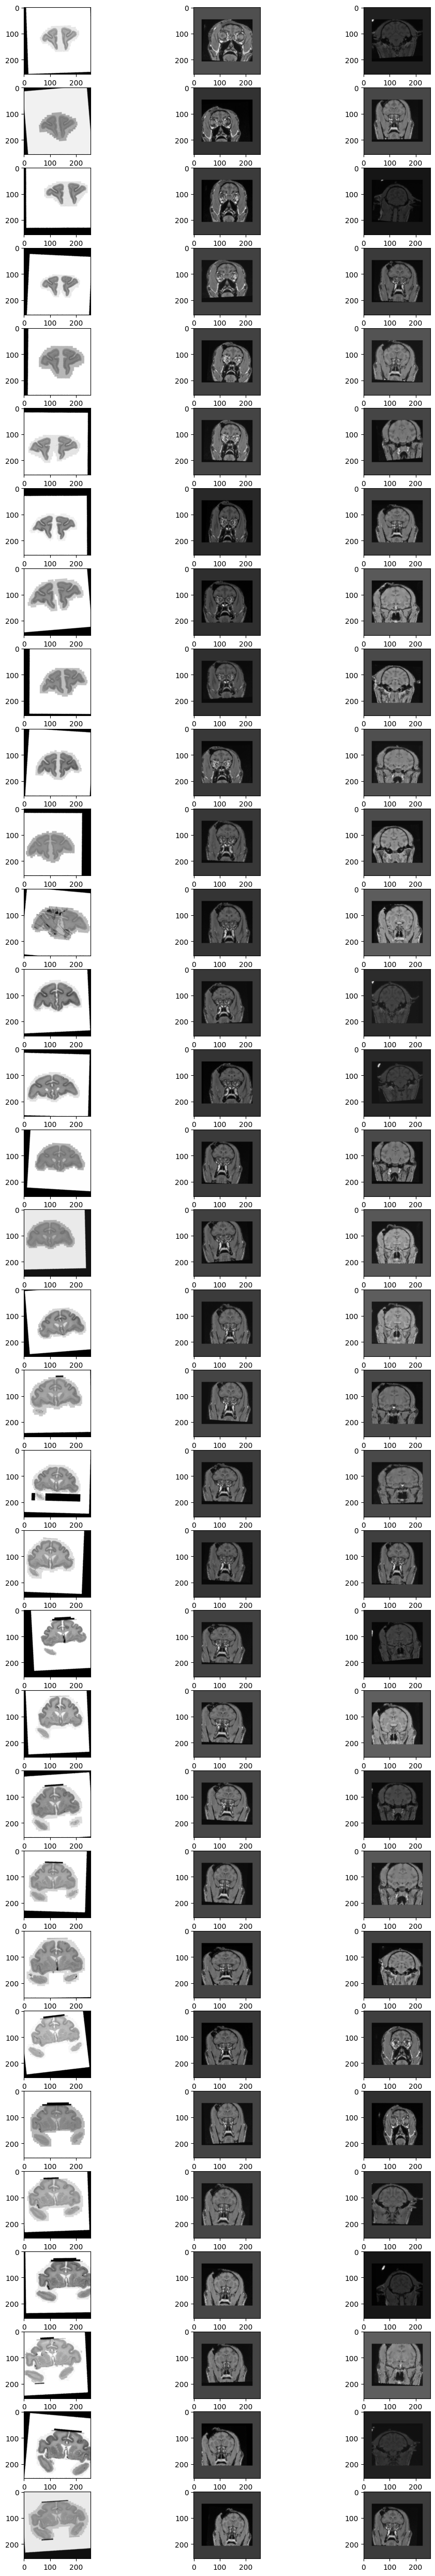

In [30]:
show_triplet_batch(test_gen_cross[0][0])

In [31]:
def generate_train_triplets(cross_histo_mri=None, only_histo=None, only_mri=None):
    all_ = []
    if cross_histo_mri is not None:
        all_ += triplets_from_raw_desc(cross_histo_mri, type_="histo")
        all_ += triplets_from_raw_desc(cross_histo_mri, type_="mri")
        all_ += triplets_from_raw_desc(cross_histo_mri, type_="random")
    
    if only_histo is not None:
        all_ += triplets_from_raw_desc(only_histo, type_="histo")
    
    if only_mri is not None:
        all_ += triplets_from_raw_desc(only_mri, type_="mri")
        
    return all_

In [32]:
for i in range(20):
    # train_triplets = triplets_from_raw_desc(train_desc, type_="mri")
    train_triplets = generate_train_triplets(train_desc, only_histo=descriptors_self, only_mri=descriptors_mri)
    enriched_descriptors = [(shmh.name, x) for x in train_triplets]
    loader = Loader(enriched_descriptors)
    gen = X0TrainGenerator(loader, batch_size=BATCH_SIZE, preprocess=preprocess_siamese)
    siamese_model.fit(gen, epochs=1, use_multiprocessing=True, workers=8)
    score = evaluate(siamese_model, test_gen_mri)
    print("Epoch", i, "\t\t", score, "mri")
    score = evaluate(siamese_model, test_gen_histo)
    print("Epoch", i, "\t\t", score, "histo")
    score = evaluate(siamese_model, test_gen_cross)
    print("Epoch", i, "\t\t", score, "cross")
    siamese_model.save_weights(f"/srv/share/models/siamese/weights_oasis_10_e{i}_s{int(score * 1000)}.h5")

20/20 [==============================] - 41s 1s/step
Epoch 0 		 0.9123630672926447 mri
21/21 [==============================] - 110s 5s/step
Epoch 0 		 0.5959438377535101 histo
21/21 [==============================] - 54s 3s/step
Epoch 0 		 0.5925349922239502 cross
20/20 [==============================] - 31s 1s/step
Epoch 1 		 0.9358372456964006 mri
21/21 [==============================] - 110s 5s/step
Epoch 1 		 0.5881435257410297 histo
21/21 [==============================] - 54s 3s/step
Epoch 1 		 0.6080870917573873 cross
20/20 [==============================] - 31s 1s/step
Epoch 2 		 0.918622848200313 mri
21/21 [==============================] - 112s 5s/step
Epoch 2 		 0.592823712948518 histo
21/21 [==============================] - 55s 3s/step
Epoch 2 		 0.5583203732503889 cross
20/20 [==============================] - 31s 1s/step
Epoch 3 		 0.9248826291079812 mri
21/21 [==============================] - 112s 5s/step
Epoch 3 		 0.6645865834633385 histo
21/21 [====================

In [33]:
res = siamese_model.predict(test_gen_cross)

21/21 [==============================] - 58s 3s/step


In [34]:
siamese_model.load_weights("/srv/share/models/siamese/weights_oasis_10_e19_s807.h5")

-0.68612194


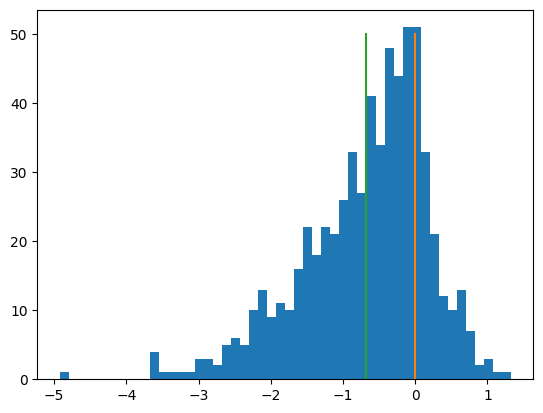

In [35]:
mn = np.mean(res[0] - res[1])
print(mn)
plt.hist(res[0] - res[1], bins=50)
plt.plot([0, 0], [0, 50])
plt.plot([mn, mn], [0, 50])
pass

[-0.08585143 -0.9629214  -0.6964279  -0.32180434 -0.44242716 -0.23567504
  0.3433286  -0.82591015 -0.2731975  -2.4222488  -0.38566253 -0.56871665
 -0.06905115 -0.08615285 -0.1788249  -2.0550644  -0.02747983 -1.3826878
 -0.4172812  -2.5081587  -0.8063445  -0.10633749  0.18060055 -0.10707512
 -0.23194468 -0.40746212 -4.9191775  -3.483007   -1.2732693  -0.75029945
 -0.12697875 -2.929681  ]


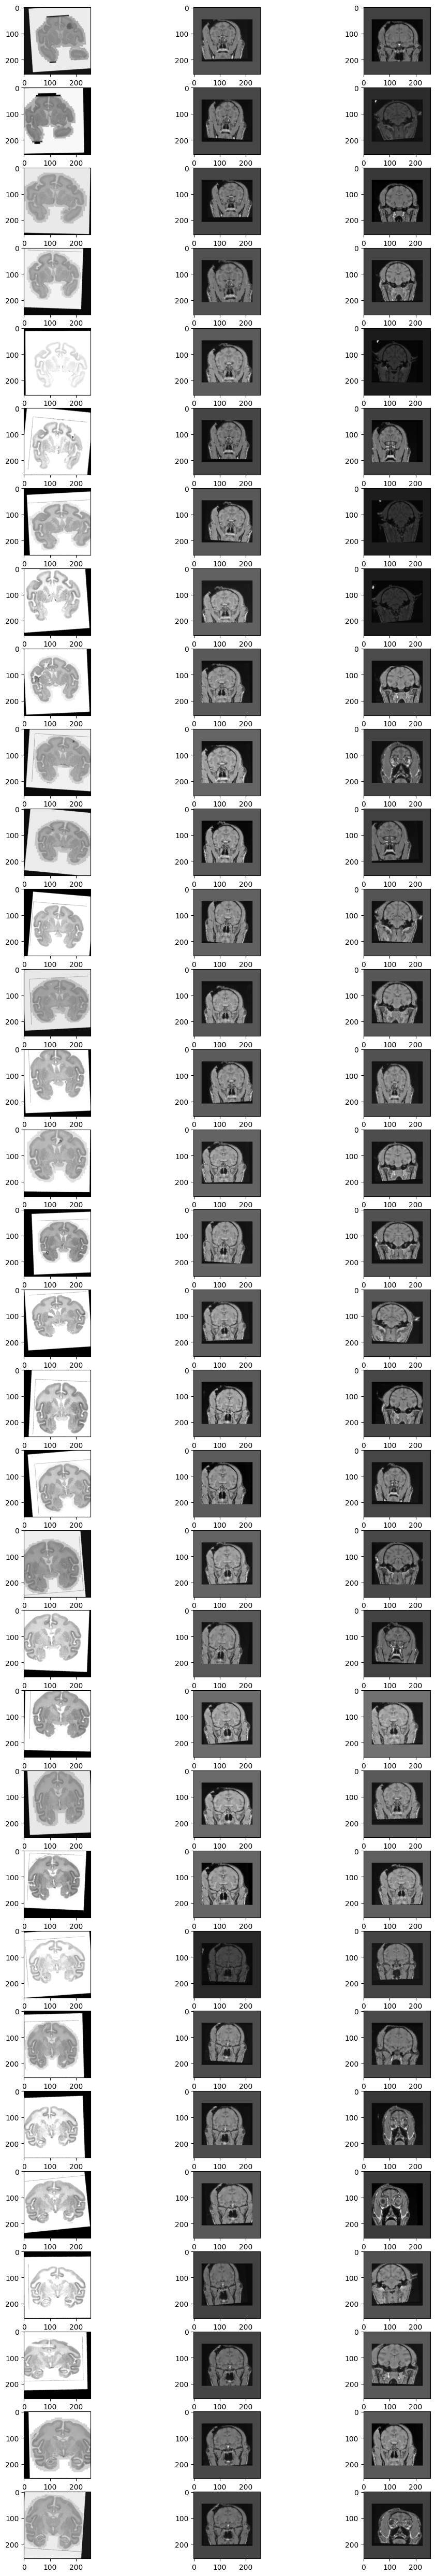

In [36]:
nbatch = 1
slices = slice(nbatch * BATCH_SIZE, (nbatch + 1) * BATCH_SIZE)
print(res[0][slices] - res[1][slices])
show_triplet_batch(test_gen_cross[nbatch][0])

In [37]:
test_gen_cross.data.data[4]

('siamese_histo_mri',
 {'anchor': {'index': 71,
   'image_name': '/srv/share/slides_512/M146 LHRH073.png',
   'mri_name': '/srv/share/MRI/M146/T1w/T1w_acpc_dc_restore.nii.gz',
   'monkey_name': 'M146',
   'slide_id': 73,
   'rotx': -2,
   'rotz': 0,
   'mri_id': 154,
   'type': 'histo'},
  'positive': {'index': 25,
   'image_name': '/srv/share/slides_512/M146 LHRH089.png',
   'mri_name': '/srv/share/MRI/M146/T1w/T1w_acpc_dc_restore.nii.gz',
   'monkey_name': 'M146',
   'slide_id': 89,
   'rotx': -2,
   'rotz': 0,
   'mri_id': 150,
   'type': 'mri'},
  'negative': {'index': 95,
   'image_name': '/srv/share/slides_512/M146 LHRH153.png',
   'mri_name': '/srv/share/MRI/M146/T1w/T1w_acpc_dc_restore.nii.gz',
   'monkey_name': 'M146',
   'slide_id': 153,
   'rotx': -2,
   'rotz': 0,
   'mri_id': 134,
   'type': 'mri'}})

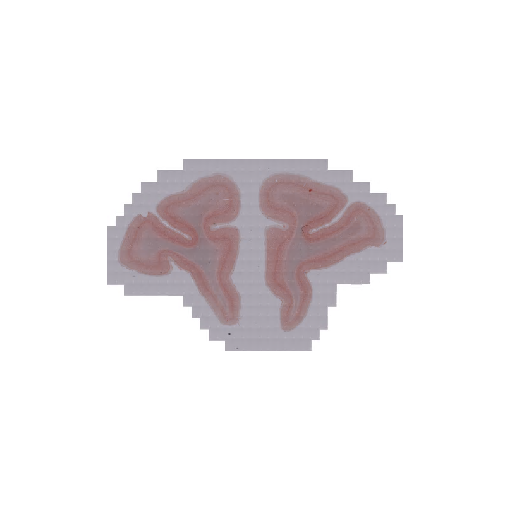

In [38]:
test_gen_cross.data[4][0][0]

In [39]:
provider